Install necessary packages

In [1]:
pip install -r /workspaces/uzh-digfintools-research/requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: '/workspaces/uzh-digfintools-research/requirements.txt'


Equity data - D&J 60 from 2019-11-01 to 2020-11-01 (source: finance yahoo)

In [153]:
import yfinance as yf
import pandas as pd
import os

tickers = ["MMM", "AXP", "AAPL", "BA", "CAT", "CVX", "CSCO", "KO", "DOW", "XOM", "GS", "HD", "IBM", "INTC", "JNJ", "JPM", "MCD", "MRK", "MSFT", "NKE", "PFE", "PG", "TRV", "UNH", "VZ", "V", "WBA", "WMT", "DIS", "RTX"]

start_date = '2019-11-01'
end_date = '2020-11-01'

data = yf.download(tickers, start=start_date, end=end_date, interval='1d')['Close']

#Gather industry data
industry_data = []
for ticker in tickers:
  stock = (yf.Ticker(ticker)).info
  info = {
      'Ticker': ticker,
      'Industry': stock.get('industry', 'N/A'),
  }
  industry_data.append(info)
industry_df = pd.DataFrame(industry_data)


[*********************100%***********************]  30 of 30 completed


Risk-free data - T-bill 10Y yield for the same time period (source: finance yahoo)

In [143]:
import yfinance as yf
import pandas as pd
import os

ticker = "^TNX"

y10_data = yf.download(ticker, start=start_date, end=end_date, interval='1d')['Close']
y10_data.head()
rf_rate = y10_data/100

descriptive_stats = rf_rate.describe()
descriptive_stats.head()

[*********************100%***********************]  1 of 1 completed


Ticker,^TNX
count,252.000000
mean,0.010363
std,0.005018
min,0.004990
25%,0.006627


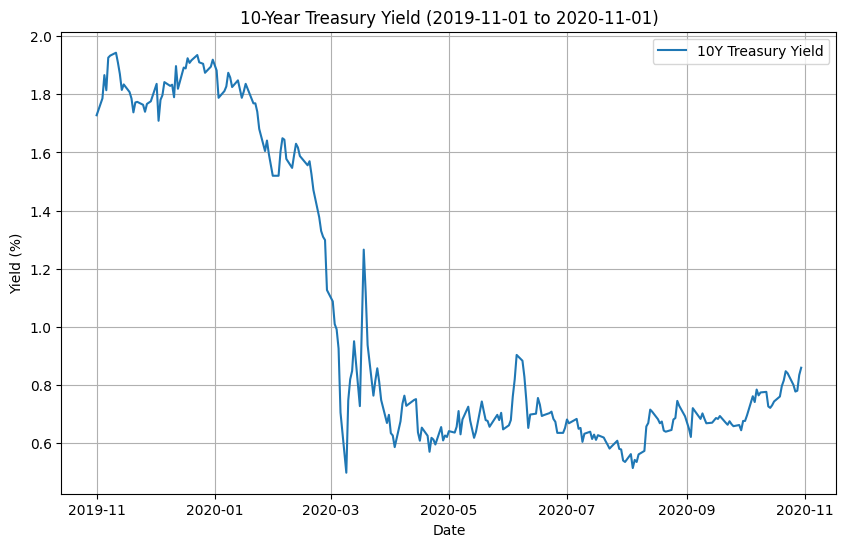

In [144]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(rf_rate*100, label='10Y Treasury Yield')
plt.title('10-Year Treasury Yield (2019-11-01 to 2020-11-01)')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True)
plt.show()

\begin{tabular}{lrrrrl}
\toprule
Ticker & Mean (%) & Variance (%) & Skewness & Kurtosis & Industry \\
\midrule
BA & -0.35 & 0.29 & -0.32 & 6.21 & Aerospace & Defense \\
RTX & -0.21 & 0.12 & -0.17 & 5.10 & Aerospace & Defense \\
JPM & -0.11 & 0.11 & -0.21 & 6.74 & Banks - Diversified \\
KO & -0.05 & 0.05 & -0.77 & 4.14 & Beverages - Non-Alcoholic \\
GS & -0.06 & 0.10 & -0.15 & 6.42 & Capital Markets \\
DOW & -0.06 & 0.15 & -1.13 & 9.67 & Chemicals \\
CSCO & -0.11 & 0.07 & -0.37 & 6.53 & Communication Equipment \\
MMM & -0.02 & 0.06 & -0.19 & 4.95 & Conglomerates \\
AAPL & 0.21 & 0.08 & -0.34 & 4.41 & Consumer Electronics \\
AXP & -0.11 & 0.14 & 0.40 & 7.39 & Credit Services \\
V & 0.00 & 0.07 & -0.14 & 7.46 & Credit Services \\
WMT & 0.07 & 0.04 & 0.95 & 9.24 & Discount Stores \\
JNJ & 0.02 & 0.04 & 0.19 & 5.48 & Drug Manufacturers - General \\
MRK & -0.05 & 0.04 & -0.11 & 4.33 & Drug Manufacturers - General \\
PFE & -0.03 & 0.04 & -0.25 & 3.95 & Drug Manufacturers - General \\
DIS & -0

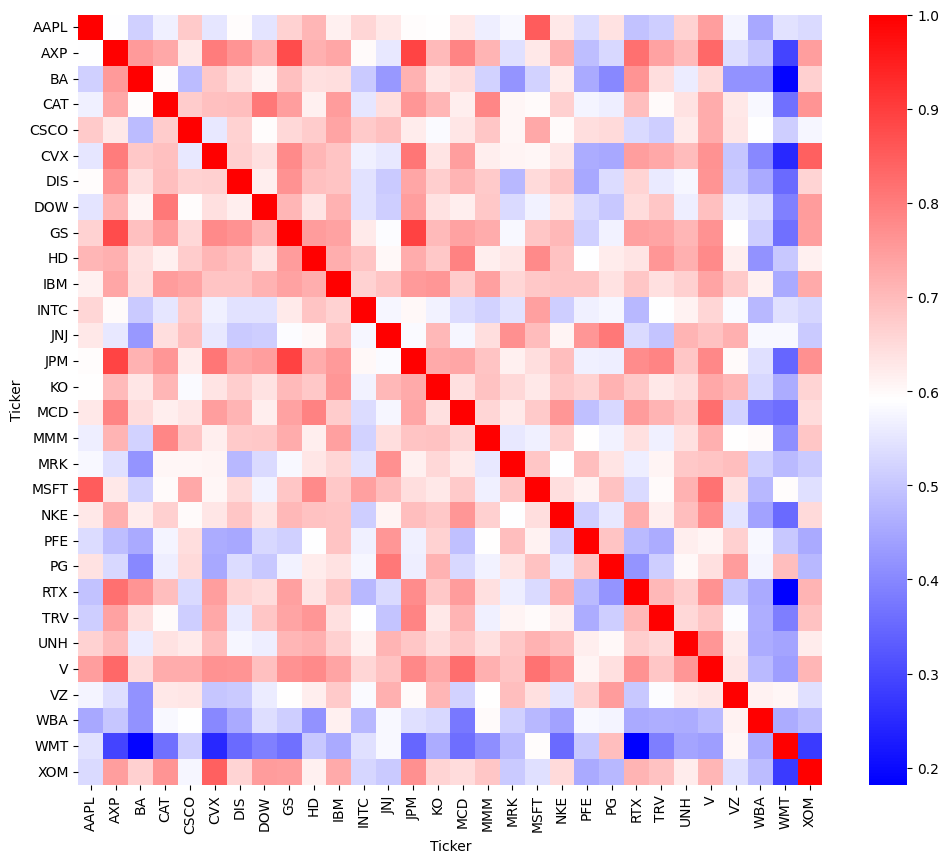

In [145]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Compute log returns
log_returns = np.log(data / data.shift(1)).dropna()

# Descriptive statistics (First 4 moments)
mean_returns = log_returns.mean()
variance = log_returns.var()
skewness = log_returns.skew()
kurtosis = log_returns.kurtosis()

# Combine the descriptive statistics into a DataFrame
descriptive_stats = pd.DataFrame({
    'Mean (%)': mean_returns*100,
    'Variance (%)': variance*100,
    'Skewness': skewness,
    'Kurtosis': kurtosis
})

# Associate with industries
descriptive_stats = descriptive_stats.merge(
    industry_df, how='left', left_on='Ticker', right_on='Ticker'
)

# Sort by Industry and Ticker for organization
descriptive_stats = descriptive_stats.sort_values(by=['Industry', 'Ticker'])

# Calculate the correlation matrix
correlation_matrix = log_returns.corr()

# Display descriptive statistics
#print("\nDescriptive Statistics (First 4 moments):\n", descriptive_stats)

#Export to Latex table
descriptive_latex = descriptive_stats.to_latex(index=False,na_rep='', float_format="%.2f")
print(descriptive_latex)


correlation_matrix = log_returns.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='bwr') #account for colorblind color palette

# Display the plot
plt.show()

In [146]:
print(descriptive_stats.head())

   Ticker  Mean (%)  Variance (%)  Skewness  Kurtosis  \
2      BA -0.347242      0.290390 -0.324005  6.213240   
22    RTX -0.211257      0.122471 -0.174238  5.097088   
13    JPM -0.105614      0.106865 -0.205374  6.741553   
14     KO -0.045689      0.045786 -0.773735  4.139190   
8      GS -0.055671      0.104008 -0.154397  6.422341   

                     Industry  
2         Aerospace & Defense  
22        Aerospace & Defense  
13        Banks - Diversified  
14  Beverages - Non-Alcoholic  
8             Capital Markets  


In [147]:
#Define target portfolio return as average daily return of DJ in October 2019

import yfinance as yf
import pandas as pd
import os
import numpy as np

ticker = "^DJI"
dji_data = yf.download(ticker, start='2019-10-01', end='2019-10-31', interval='1d')['Close']
dji_log_returns = np.log(dji_data / dji_data.shift(1)).dropna()
p0 = np.mean(dji_log_returns)
print(p0)


[*********************100%***********************]  1 of 1 completed

0.001087160118374933


Markowtiz optimisation set up

In [150]:
import numpy as np


fc = 21 #forecasting period: 21 - monthly
rb = 10 #rebalancing: 10 - biweekly
n = log_returns.shape[1] #number of securities
tdays = log_returns.shape[0]
tperiods = int(( tdays - fc) / rb) - 1 #number of forecasting periods
eqw = np.full(n, 1 / n)  # Equally weighted portfolio


results_minvar = {
    'volatility_p': [],
    'return_p': [],
    'sharpe_ratio_p': [],
    'volatility_eqw': [],
    'return_eqw': [],
    'sharpe_ratio_eqw': [],
    'volatility_diff': [],
    'return_diff': [],
    'sharpe_ratio_diff': []
}


results_maxsr = {
    'volatility_p': [],
    'return_p': [],
    'sharpe_ratio_p': [],
    'volatility_eqw': [],
    'return_eqw': [],
    'sharpe_ratio_eqw': [],
    'volatility_diff': [],
    'return_diff': [],
    'sharpe_ratio_diff': []
}

riskfree_rate = rf_rate.values

In [68]:
tperiods

22

Minimum variance optimisation

In [151]:
import cvxopt
import numpy as np

cvxopt.solvers.options['show_progress'] = True

for i in range(tperiods):
    # Extract the rolling window
    window = log_returns.iloc[i * rb: fc + i * rb, :]
    window_cov = window.cov()
    log_returns_target = np.mean(window, axis=0)

    # Convert to cvxopt.matrix
    P = 2*cvxopt.matrix(window_cov.values)
    eigenvalues = np.linalg.eigvalsh(P)  # For projection method
    print("Is the matrix PSD?", np.all(eigenvalues >= 0))
    q = cvxopt.matrix(np.zeros(n)) # No linear term in minimisation problem

    # Constraints: no short selling (weights >= 0) and minimum portfolio return constraint
    G = cvxopt.matrix(np.vstack([-np.eye(n), log_returns_target]))
    h = cvxopt.matrix(np.append(np.zeros(n), -p0))

    # Fully invested portfolio: sum of weights = 1
    A = cvxopt.matrix(np.ones([1, n]))
    b = cvxopt.matrix([1.0])

    #Run optimisation problem
    sol = cvxopt.solvers.qp(P,q, G, h, A, b)

    #Check for optimisation failures
    if sol['status'] != 'optimal':
        print(f"Optimisation failed at iteration {i}")
        continue

    #Extract optimised weights
    weights = np.array(sol['x']).flatten()

    #Back-testing

    return_bt = log_returns.iloc[fc + (i + 1) * rb, :].values #Realised return
    variance_bt = log_returns.iloc[i * rb: fc + (i + 1) * rb, :].cov() #Realised covariance

    # Optimal portfolio variance, return and sharpe ratio calculatoin
    variance_p = weights.T @ variance_bt @ weights #Potrfolio variance (daily data)
    volatility_p = np.sqrt(variance_p) #Portfolio volatility (daily data)
    return_p = weights.T @ return_bt #Portfolio return daily
    sr_p = (return_p - riskfree_rate[i])/volatility_p #Portfolio Sharpe ratio

    #Calculate performance of benchmark - equally weighted portfolio
    volatility_bench = np.sqrt(eqw.T @ variance_bt @ eqw) #Benchmark variance (daily data)
    return_bench = eqw.T@return_bt #Benchmark daily returns
    sr_bench = (return_bench - riskfree_rate[i])/volatility_bench #Benchmark Sharpe ratio

    #Calculate differences in performance measures for optimised portfolio against benchmark
    volatility_diff = volatility_p-volatility_bench #Difference in volatility
    return_diff = return_p - return_bench #Difference in daily returns
    sr_diff = sr_p - sr_bench #Difference in Sharpe ratios

    # Store results
    results_minvar['volatility_p'].append(volatility_p)
    results_minvar['return_p'].append(return_p)
    results_minvar['sharpe_ratio_p'].append(sr_p)
    results_minvar['volatility_eqw'].append(volatility_bench)
    results_minvar['return_eqw'].append(return_bench)
    results_minvar['sharpe_ratio_eqw'].append(sr_bench)
    results_minvar['volatility_diff'].append(volatility_diff)
    results_minvar['return_diff'].append(return_diff)
    results_minvar['sharpe_ratio_diff'].append(sr_diff)




Is the matrix PSD? False
     pcost       dcost       gap    pres   dres
 0:  1.7618e-05 -9.9878e-01  3e+01  6e+00  6e+00
 1:  1.7655e-05 -9.3611e-01  1e+00  6e-02  6e-02
 2:  1.7665e-05 -1.7391e-01  2e-01  7e-03  7e-03
 3:  1.9967e-05 -1.2656e-01  2e-01  6e-03  6e-03
 4:  3.4981e-05 -6.6364e-02  7e-02  2e-16  7e-16
 5:  3.4918e-05 -7.0525e-04  7e-04  2e-16  1e-16
 6:  3.0713e-05 -3.4619e-05  7e-05  2e-16  1e-17
 7:  1.3753e-05 -7.5290e-06  2e-05  2e-16  2e-19
 8:  9.7211e-06  6.0035e-06  4e-06  4e-17  1e-19
 9:  7.9972e-06  7.6687e-06  3e-07  6e-17  3e-19
10:  7.7962e-06  7.7814e-06  1e-08  9e-17  6e-19
Optimal solution found.
Is the matrix PSD? False
     pcost       dcost       gap    pres   dres
 0:  2.5580e-05 -9.9819e-01  3e+01  6e+00  6e+00
 1:  2.5615e-05 -9.3559e-01  1e+00  7e-02  7e-02
 2:  2.5620e-05 -2.1772e-01  2e-01  1e-02  1e-02
 3:  2.6609e-05 -1.6066e-01  2e-01  9e-03  9e-03
 4:  3.9819e-05 -9.7003e-02  1e-01  2e-16  4e-16
 5:  3.9778e-05 -1.0670e-03  1e-03  1e-16  2e-

Maximum Sharpe Ratio

In [152]:
import cvxopt
import numpy as np

cvxopt.solvers.options['show_progress'] = False

for i in range(tperiods):
    # Extract the rolling window
    window = log_returns.iloc[i * rb: fc + i * rb, :]
    window_cov = window.cov()
    log_returns_target = np.mean(window, axis=0)

    # Calculate the excess returns (numerator in Sharpe ratio formula)
    excess_returns = log_returns_target - riskfree_rate[i]

    # Initialize quadratic programming problem to maximize Sharpe ratio
    P = cvxopt.matrix(window_cov.values)  # Covariance matrix (for variance minimization)
    q = cvxopt.matrix(-excess_returns)    # Negative of the excess returns (we want to maximize returns)

    # Constraints: no short selling (weights >= 0)
    G = cvxopt.matrix(np.vstack([-np.eye(n)]))
    h = cvxopt.matrix(np.zeros(n))

    # Fully invested portfolio: sum of weights = 1
    A = cvxopt.matrix(np.ones([1, n]))
    b = cvxopt.matrix([1.0])

    # Run optimization problem
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)

    if sol['status'] != 'optimal':
        print(f"Optimization failed at iteration {i}")
        continue

    weights = np.array(sol['x']).flatten()  # Optimal weights

    #Back-testing

    return_bt = log_returns.iloc[fc + (i + 1) * rb, :].values #Realised return
    variance_bt = log_returns.iloc[i * rb: fc + (i + 1) * rb, :].cov() #Realised covariance

    # Optimal portfolio variance, return and sharpe ratio calculatoin
    variance_p = weights.T @ variance_bt @ weights #Potrfolio variance (daily data)
    volatility_p = np.sqrt(variance_p) #Portfolio volatility (daily data)
    return_p = weights.T @ return_bt #Portfolio return daily
    sr_p = (return_p - riskfree_rate[i])/volatility_p #Portfolio Sharpe ratio

    #Calculate performance of benchmark - equally weighted portfolio
    volatility_bench = np.sqrt(eqw.T @ variance_bt @ eqw) #Benchmark variance (daily data)
    return_bench = eqw.T@return_bt #Benchmark daily returns
    sr_bench = (return_bench - riskfree_rate[i])/volatility_bench #Benchmark Sharpe ratio

    #Calculate differences in performance measures for optimised portfolio against benchmark
    volatility_diff = volatility_p-volatility_bench #Difference in volatility
    return_diff = return_p - return_bench #Difference in daily returns
    sr_diff = sr_p - sr_bench #Difference in Sharpe ratios

    # Store results
    results_maxsr['volatility_p'].append(volatility_p)
    results_maxsr['return_p'].append(return_p)
    results_maxsr['sharpe_ratio_p'].append(sr_p)
    results_maxsr['volatility_eqw'].append(volatility_bench)
    results_maxsr['return_eqw'].append(return_bench)
    results_maxsr['sharpe_ratio_eqw'].append(sr_bench)
    results_maxsr['volatility_diff'].append(volatility_diff)
    results_maxsr['return_diff'].append(return_diff)
    results_maxsr['sharpe_ratio_diff'].append(sr_diff)

Plots

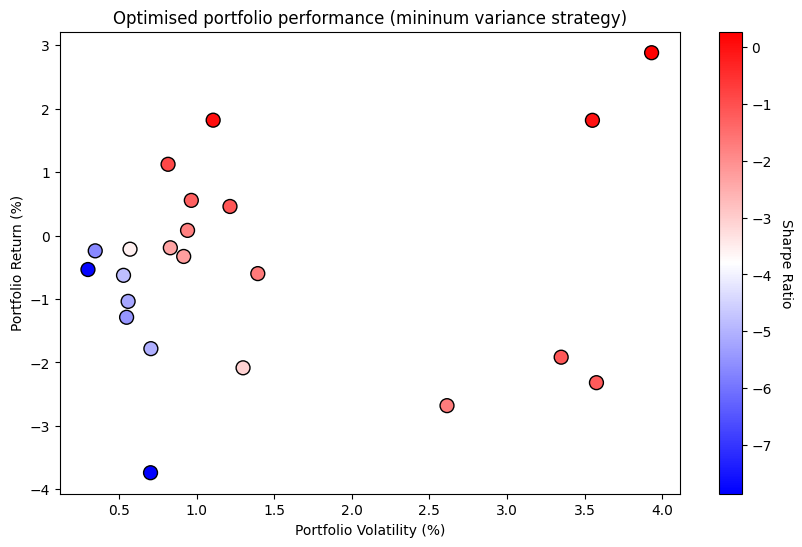

In [15]:
# Scatter plot for Minimum Variance Strategy
plt.figure(figsize=(10, 6))

# Extracting data for the minimum variance strategy
returns_minvar = np.array(results_minvar['return_p'])*100  # Portfolio returns
volatility_minvar = np.array(results_minvar['volatility_p'])*100  # Portfolio volatility
sharpe_ratios_minvar = np.array(results_minvar['sharpe_ratio_p'])  # Sharpe ratios

# Scatter plot with Sharpe ratio as color
sc_minvar = plt.scatter(volatility_minvar, returns_minvar, c=sharpe_ratios_minvar, cmap='bwr', s=100, edgecolor='k')
cbar_minvar = plt.colorbar(sc_minvar)
cbar_minvar.set_label('Sharpe Ratio', rotation=270, labelpad=15)

plt.xlabel('Portfolio Volatility (%)')
plt.ylabel('Portfolio Return (%)')
plt.title('Optimised portfolio performance (mininum variance strategy)')
plt.show()

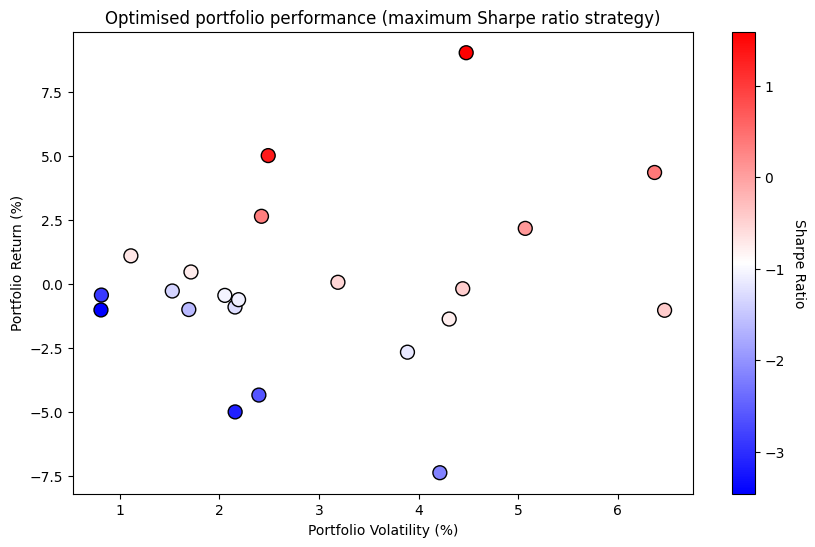

In [16]:
# Scatter plot for Maximum Sharpe Ratio Strategy
plt.figure(figsize=(10, 6))

# Extracting data for the maximum Sharpe ratio strategy
returns_maxsr = np.array(results_maxsr['return_p'])*100  # Portfolio returns
volatility_maxsr = np.array(results_maxsr['volatility_p'])*100  # Portfolio volatilities (already sqrt of variance)
sharpe_ratios_maxsr = np.array(results_maxsr['sharpe_ratio_p'])  # Sharpe ratios

# Scatter plot with Sharpe ratio as color
sc_maxsr = plt.scatter(volatility_maxsr, returns_maxsr, c=sharpe_ratios_maxsr, cmap='bwr', s=100, edgecolor='k')
cbar_maxsr = plt.colorbar(sc_maxsr)
cbar_maxsr.set_label('Sharpe Ratio', rotation=270, labelpad=15)

plt.xlabel('Portfolio Volatility (%)')
plt.ylabel('Portfolio Return (%)')
plt.title('Optimised portfolio performance (maximum Sharpe ratio strategy)')
plt.show()

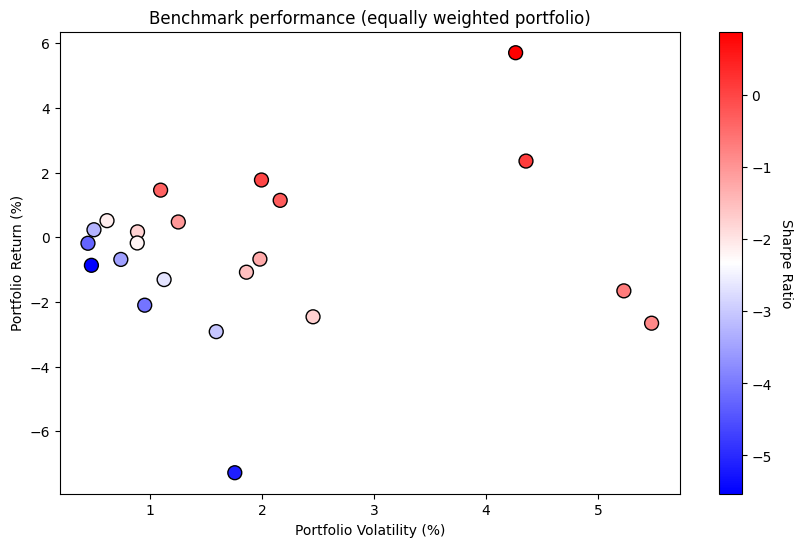

In [ ]:
# Scatter plot for benchmark portfolio
plt.figure(figsize=(10, 6))

# Extracting data for benchmark
returns_b = np.array(results_maxsr['return_eqw'])*100  # Portfolio returns
volatility_b = np.array(results_maxsr['volatility_eqw'])*100  # Portfolio volatilities (already sqrt of variance)
sharpe_ratios_b = np.array(results_maxsr['sharpe_ratio_eqw'])  # Sharpe ratios

# Scatter plot with Sharpe ratio as color
sc_b = plt.scatter(volatility_b, returns_b, c=sharpe_ratios_b, cmap='bwr', s=100, edgecolor='k')
cbar_b = plt.colorbar(sc_b)
cbar_b.set_label('Sharpe Ratio', rotation=270, labelpad=15)

plt.xlabel('Portfolio Volatility (%)')
plt.ylabel('Portfolio Return (%)')
plt.title('Benchmark performance (equally weighted portfolio)')
plt.show()

In [ ]:
#Generate dates

import pandas as pd
# The initial start date
start_date = pd.to_datetime("2019-11-01")
end_date = pd.to_datetime("2020-11-01")
start_f_date = start_date + pd.tseries.offsets.BDay(fc) #forecasting period using as step
dates_df = pd.date_range(start=start_f_date, end=end_date, periods=tperiods)
len(dates_df)

22

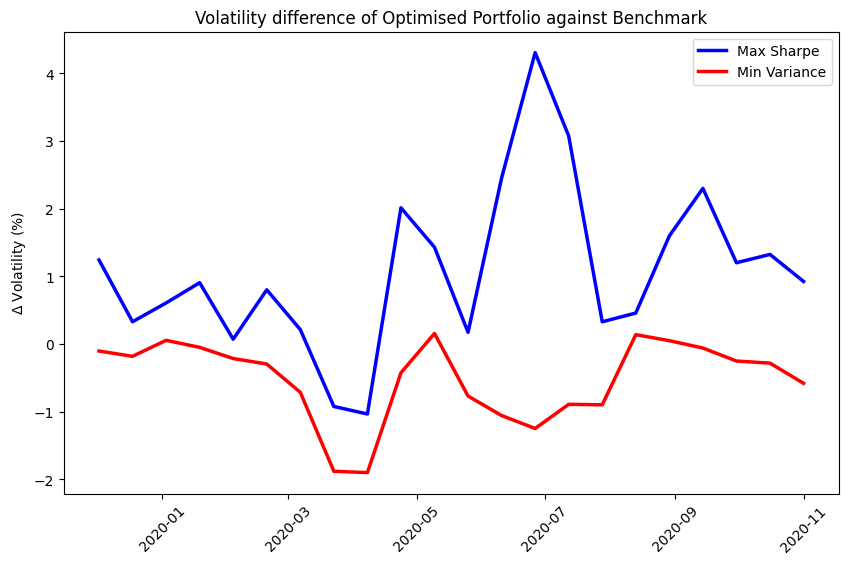

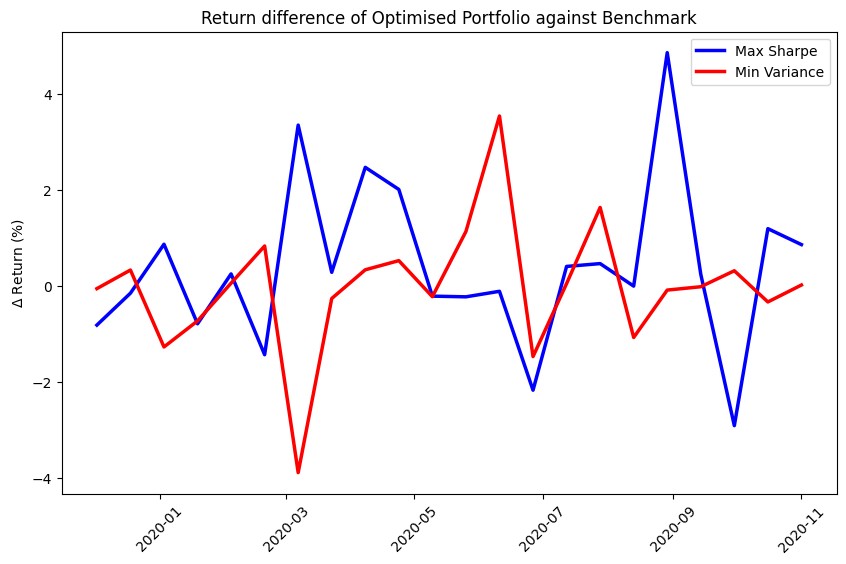

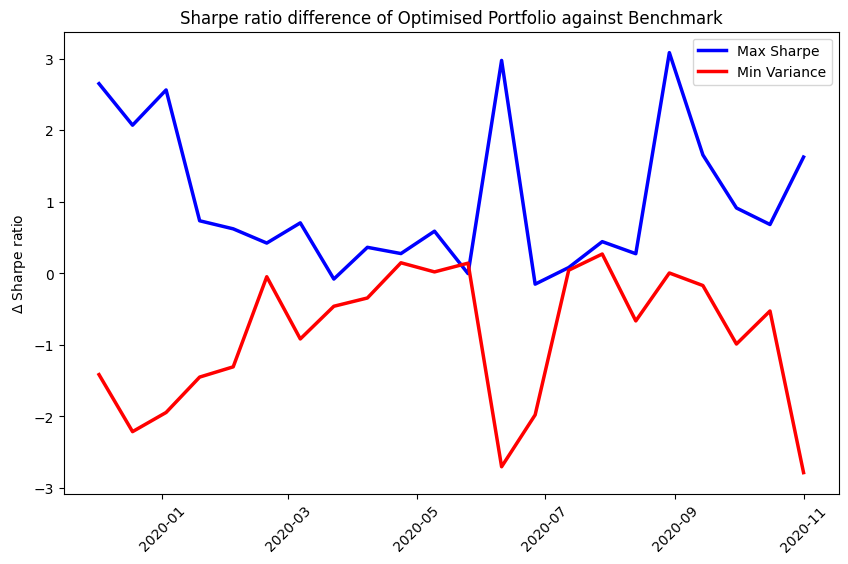

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plotting volatility for both portfolios
plt.figure(figsize=(10, 6))
plt.plot(dates_df, np.array(results_maxsr['volatility_diff'])*100, label="Max Sharpe", color='blue', linewidth=2.5)
plt.plot(dates_df, np.array(results_minvar['volatility_diff'])*100, label="Min Variance", color='red', linewidth=2.5)
plt.ylabel("$\Delta$ Volatility (%)")
plt.title("Volatility difference of Optimised Portfolio against Benchmark")
plt.xticks(rotation=45)
plt.legend()
plt.show()


# Plotting returns for both portfolios
plt.figure(figsize=(10, 6))
plt.plot(dates_df, np.array(results_maxsr['return_diff'])*100, label="Max Sharpe", color='blue', linewidth=2.5)
plt.plot(dates_df, np.array(results_minvar['return_diff'])*100, label="Min Variance", color='red', linewidth=2.5)
plt.ylabel("$\Delta$ Return (%)")
plt.title("Return difference of Optimised Portfolio against Benchmark")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plotting Sharpe ratio difference for both portfolios
plt.figure(figsize=(10, 6))
plt.plot(dates_df, results_maxsr['sharpe_ratio_diff'], label="Max Sharpe", color='blue', linewidth=2.5)
plt.plot(dates_df, results_minvar['sharpe_ratio_diff'], label="Min Variance", color='red', linewidth=2.5)
plt.ylabel("$\Delta$ Sharpe ratio")
plt.title("Sharpe ratio difference of Optimised Portfolio against Benchmark")
plt.xticks(rotation=45)
plt.legend()
plt.show()